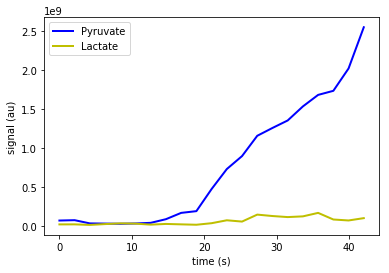

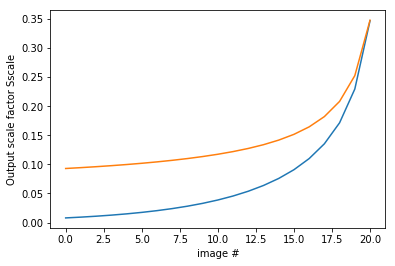

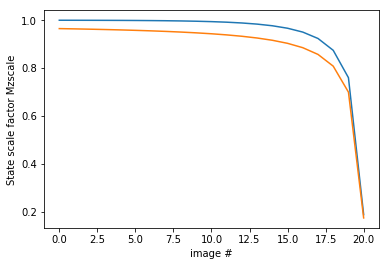

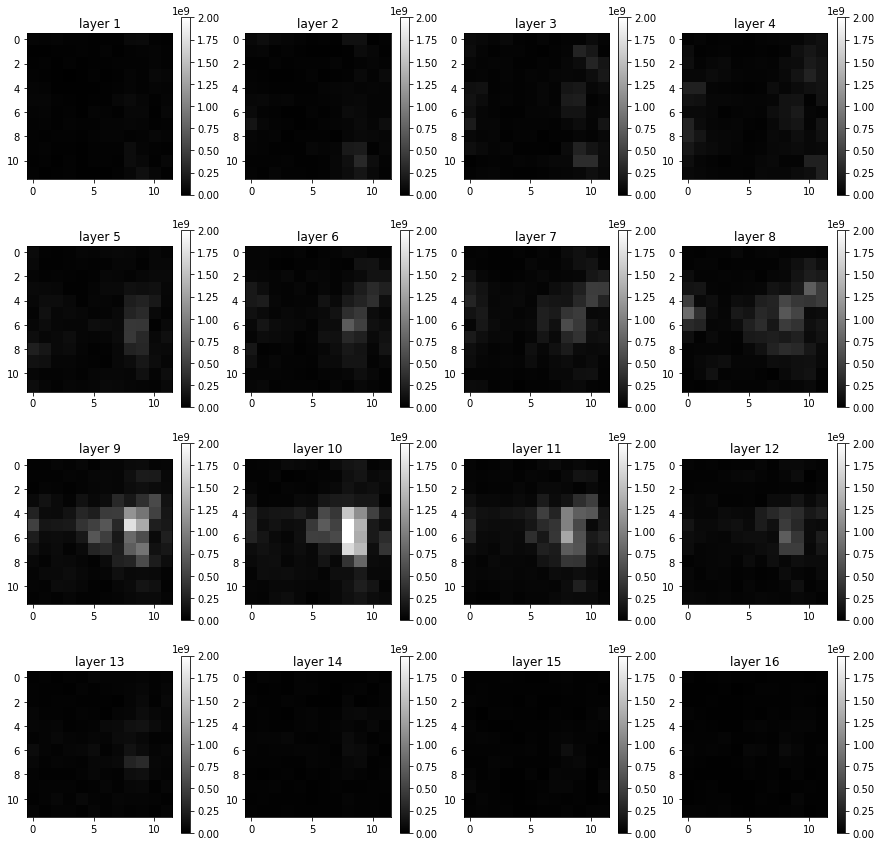

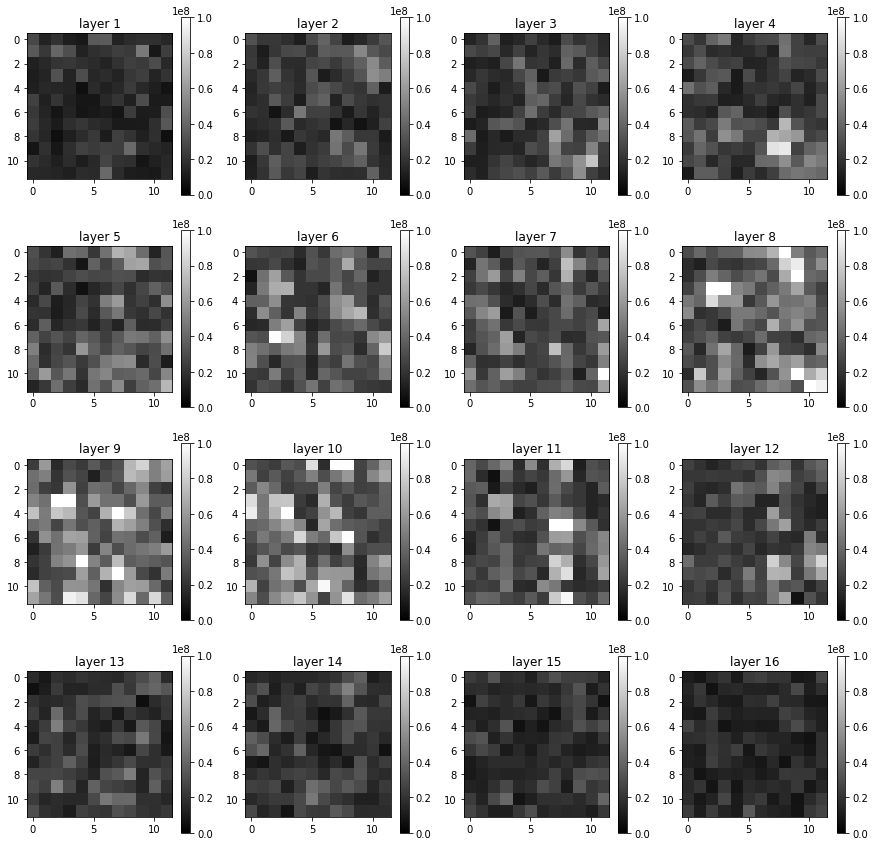

In [1]:
import numpy
import matplotlib.pyplot as plt
import scipy.optimize as optimization
from math import sqrt
%matplotlib inline
import scipy.io

filename = 'pc9375_data'
matlab_data = scipy.io.loadmat(filename + '.mat')
data = numpy.zeros((12, 12, 16, 2, 21))
data[:, :, :, :, :] = matlab_data['peaks']
Sscale = matlab_data['Sscale']
Mzscale = matlab_data['Mzscale']
data = numpy.transpose(data, (0, 1, 2, 4, 3))


# setup model parameters 
dt      = 2.0
R1L     = 1.0/60.0
R1P     = 1.0/60.0
P0      = 1.2e13
sigma   = 3000.0
kTRANS  = 0.05
kPL     = 0.07
N       = 21
Nz      = 16
params  = numpy.array([dt, N, R1L, R1P, P0, sigma])

# plot time series from a particular voxel 
plt.plot(dt*numpy.linspace(0, N, N), data[6, 8, 9, :, 0], 'b-', linewidth=2)
plt.plot(dt*numpy.linspace(0, N, N), data[6, 8, 9, :, 1], 'y-', linewidth=2)
plt.legend(('Pyruvate', 'Lactate'), loc='upper left')
plt.xlabel('time (s)')
plt.ylabel('signal (au)')
plt.savefig('pc_data_3D_time_series.png', bbox_inches='tight')
plt.show()

# plot Sscale (output scale factor) corresponding to flip angle sequence
plt.plot(Sscale.T)
plt.xlabel('image #')
plt.ylabel('Output scale factor Sscale')
plt.show()

# plot Mzscale (state scale factor) corresponding to flip angle sequence
plt.plot(Mzscale.T)
plt.xlabel('image #')
plt.ylabel('State scale factor Mzscale')
plt.show()

# plot pyruvate data at some time 
plt.figure(figsize = (15,15))
for i in range(Nz):
    plt.subplot(4, 4, i+1)
    plt.imshow(data[:, :, i, -1, 0], cmap="gray", vmin=0, vmax=2e9, interpolation="nearest")
    #plt.xticks([])
    #plt.yticks([])
    plt.colorbar()
    plt.title("layer " + str(i+1))
plt.savefig('pc_data_3D_pyruvate_images.png', bbox_inches='tight')
plt.show()

# plot lactate data at some time 
plt.figure(figsize = (15,15))
for i in range(Nz):
    plt.subplot(4, 4, i+1)
    plt.imshow(data[:, :, i, -1, 1], cmap="gray", vmin=0, vmax=1e8, interpolation="nearest")
    #plt.xticks([])
    #plt.yticks([])
    plt.colorbar()
    plt.title("layer " + str(i+1))
plt.savefig('pc_data_3D_lactate_images.png', bbox_inches='tight')
plt.show()

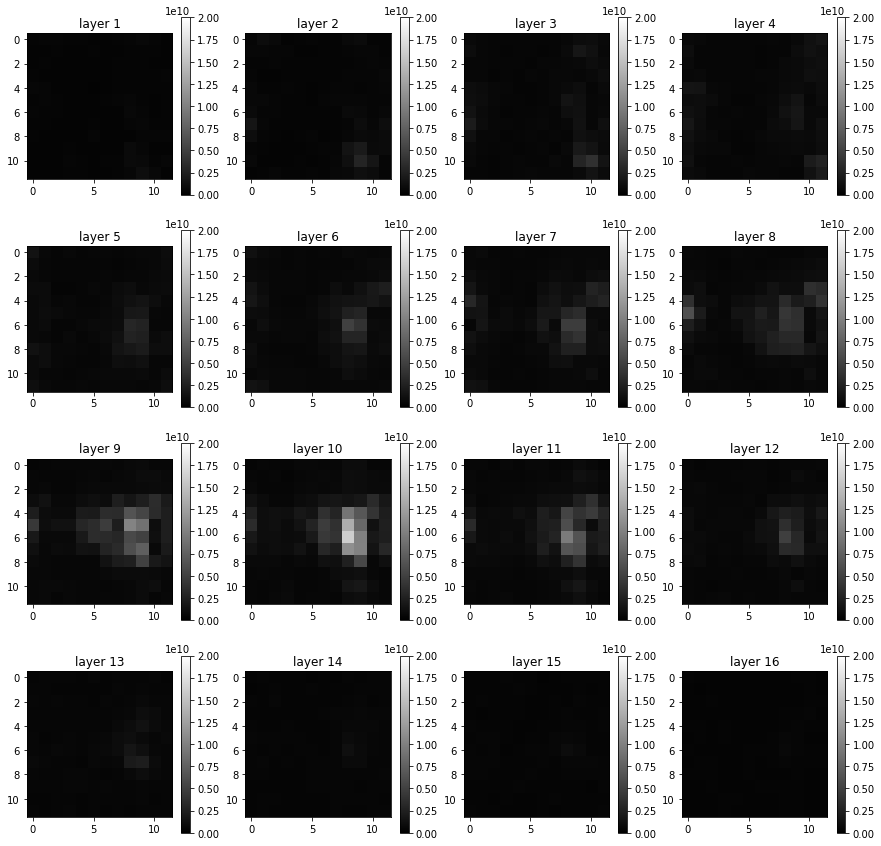

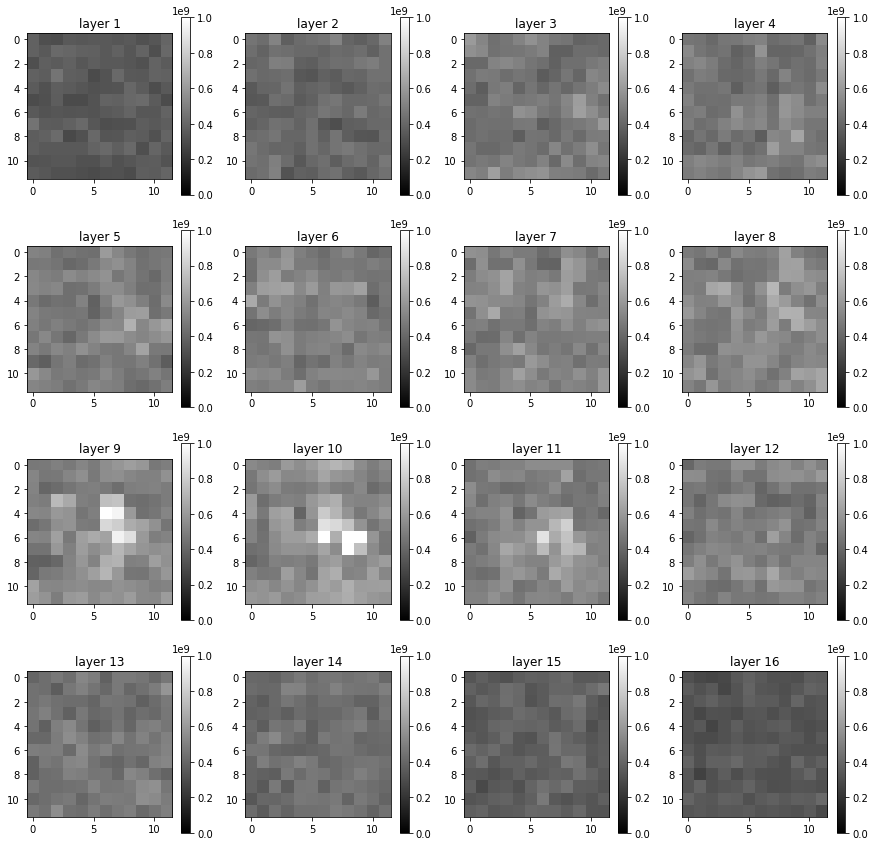

In [2]:
# result of temporal averaging (Area under the curve)

# pyruvate
plt.figure(figsize = (15, 15))
for i in range(Nz):
    plt.subplot(4, 4, i+1)
    plt.imshow(numpy.sum(data[:, :, i, :, 0], 2), cmap="gray", vmin=0, vmax=2e10, interpolation="nearest")
    #plt.xticks([])
    #plt.yticks([])
    plt.colorbar()
    plt.title("layer " + str(i+1))
plt.show()

# lactate
plt.figure(figsize = (15, 15))
for i in range(Nz):
    plt.subplot(4, 4, i+1)
    plt.imshow(numpy.sum(data[:, :, i, :, 1], 2), cmap="gray", vmin=0, vmax=1e09, interpolation="nearest")
    #plt.xticks([])
    #plt.yticks([])
    plt.colorbar()
    plt.title("layer " + str(i+1))
plt.show()

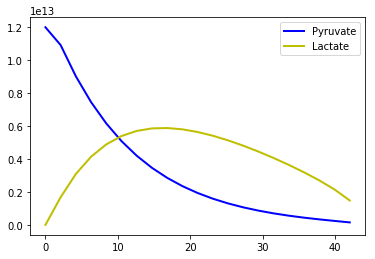

kPL test fit value =  [0.00719154]
kPL test fit value =  [0.05 0.07]


In [3]:
# Define functions for fitting model to data 

def trajectories(kTRANS, kPL, params, Mzscale, Sscale, u): 
    # FUNCTION TRAJECTORIES computes trajectories of the model 
    
    # unpack params 
    dt    = params[0]
    N     = int(params[1])
    R1L   = params[2]
    R1P   = params[3]
    P0    = params[4]
    sigma = params[5]
    
    Ad = numpy.eye(2) + dt*numpy.array([[-kPL-R1P, 0],[kPL, -R1L]]) 
    
    x = numpy.zeros((2, N+1))
    x[0, 0] = P0
    for t in range(N):
        x[:, t+1] = numpy.dot(Ad, Mzscale[:, t]*x[:, t])  + dt*u[t]*numpy.array([kTRANS, 0])
        
    y = x[:, :-1]*Sscale
    return x[:, :-1].T
        
    
    # compute pyruvate and lactate trajectories using analytical solution to linear ODE
    # P = kTRANS*P0*numpy.exp(-(R1P + kPL)*dt*numpy.linspace(0, N-1, N))
    # if (abs(R1L - R1P - kPL) > 1e-06):
    #     L = kTRANS*kPL*P0/(R1L - R1P - kPL) * (numpy.exp(-(R1P + kPL)*dt*numpy.linspace(0, N-1, N)) - numpy.exp(-R1L*dt*numpy.linspace(0, N-1, N)))
    # else:
    #     L = kTRANS*kPL*P0*dt*numpy.linspace(0, N-1, N)*numpy.exp(-R1L*dt*numpy.linspace(0, N-1, N))        
                
    # return matrix of trajectories [P(t) L(t)]
    # return (numpy.vstack((P, L))*Mzscale*Sscale).T
    
def traj_1D(kPL, params, Mzscale, Sscale, y1):
    
    # y1 should be the (unscaled) output data from the pyruvate channel
    
    # unpack params 
    dt    = params[0]
    N     = int(params[1])
    R1L   = params[2]
    R1P   = params[3]
    P0    = params[4]
    sigma = params[5]
    
    x1 = y1/Sscale[0, :]
        
    x2 = numpy.zeros(N) 
    for t in range(N-1):
        x2[t+1] = (-(kPL*numpy.exp((- R1P - kPL)*dt) - kPL*numpy.exp(-R1L*dt))/(R1P - R1L + kPL))*Mzscale[0, t]*x1[t]  +  numpy.exp(-R1L*dt)*Mzscale[1, t]*x2[t]
    return x2*Sscale[1, :]

def maximum_likelihood_fit(data, params, Mzscale, Sscale, u): 
    # data represents times series from a particular voxel 
    
    # unpack params 
    dt    = params[0]
    N     = int(params[1])
    R1L   = params[2]
    R1P   = params[3]
    P0    = params[4]
    sigma = params[5]
        
    def func(theta, params, Y):
        return (Y - trajectories(theta[0], theta[1], params, Mzscale, Sscale, u)).flatten()
    
    # res = optimization.curve_fit(func, xdata, ydata, x0, sigma)
    x0  = numpy.array([0.05, 0.07])
    res = optimization.leastsq(func, x0, args=(params, data))

    return res[0]

def assumptionless_fit(data, params, Mzscale, Sscale):
    
    # unpack params 
    dt    = params[0]
    N     = int(params[1])
    R1L   = params[2]
    R1P   = params[3]
    P0    = params[4]
    sigma = params[5]
    
    def func(theta, params, data):
        return (data[:, 1] - traj_1D(theta, params, Mzscale, Sscale, data[:, 0]))
    
    theta0  = numpy.array([0.07])
    res = optimization.leastsq(func, theta0, args=(params, data))

    return res[0]

# arterial input
u0 = numpy.zeros(N)
u0[0] = 1e13
# u[8:] = 0

# generate simulated data 
y = trajectories(kTRANS, kPL, params, Mzscale, Sscale, u0)

# plot simulated trajectories 
plt.plot(dt*numpy.linspace(0, N, N), y[:, 0], 'b-', linewidth=2)
plt.plot(dt*numpy.linspace(0, N, N), y[:, 1], 'y-', linewidth=2)
plt.legend(('Pyruvate', 'Lactate'))
plt.show()

# test assumption-less fit 
kPL_test_fit = assumptionless_fit(y, params, Mzscale, Sscale)
print "kPL test fit value = ", kPL_test_fit

# test maximum-likelihood fit 
kPL_test_fit = maximum_likelihood_fit(y, params, Mzscale, Sscale, u0)
print "kPL test fit value = ", kPL_test_fit

In [4]:
# loop assumptionless fit
def loop_assumptionless_fit(data, params, Mzscale, Sscale):
    kPL_fit_array = numpy.zeros(data.shape[0:3])
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            for k in range(data.shape[2]):
                kPL_fit_array[i, j, k] = assumptionless_fit(data[i, j, k, :, :], params, Mzscale, Sscale)
    return kPL_fit_array
                
# test this function 
kPL_fit = loop_assumptionless_fit(data, params, Mzscale, Sscale)

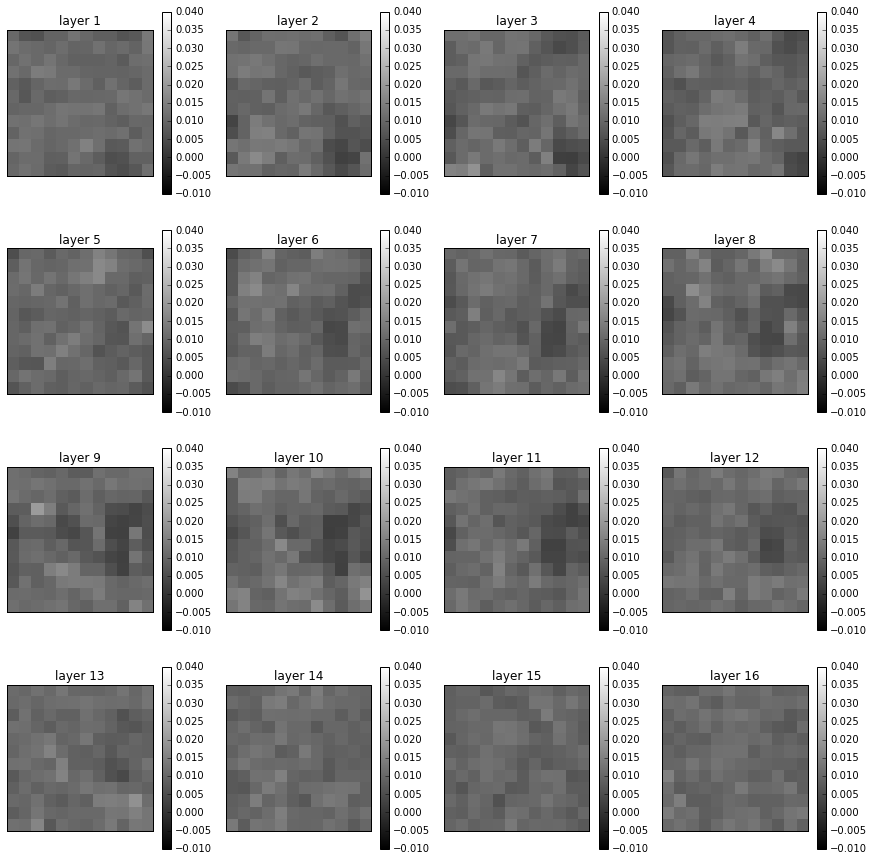

In [5]:
# plot results of independent voxel-wise fit 

plt.figure(figsize = (15,15))
for i in range(Nz):
    plt.subplot(4, 4, i+1)
    plt.imshow(kPL_fit[:, :, i], cmap="gray", vmin=-0.01, vmax=0.04, interpolation="nearest")
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.title("layer " + str(i+1))
plt.savefig('pc_data_3D_kPL_map_no_regularization.png', bbox_inches='tight')
plt.show()

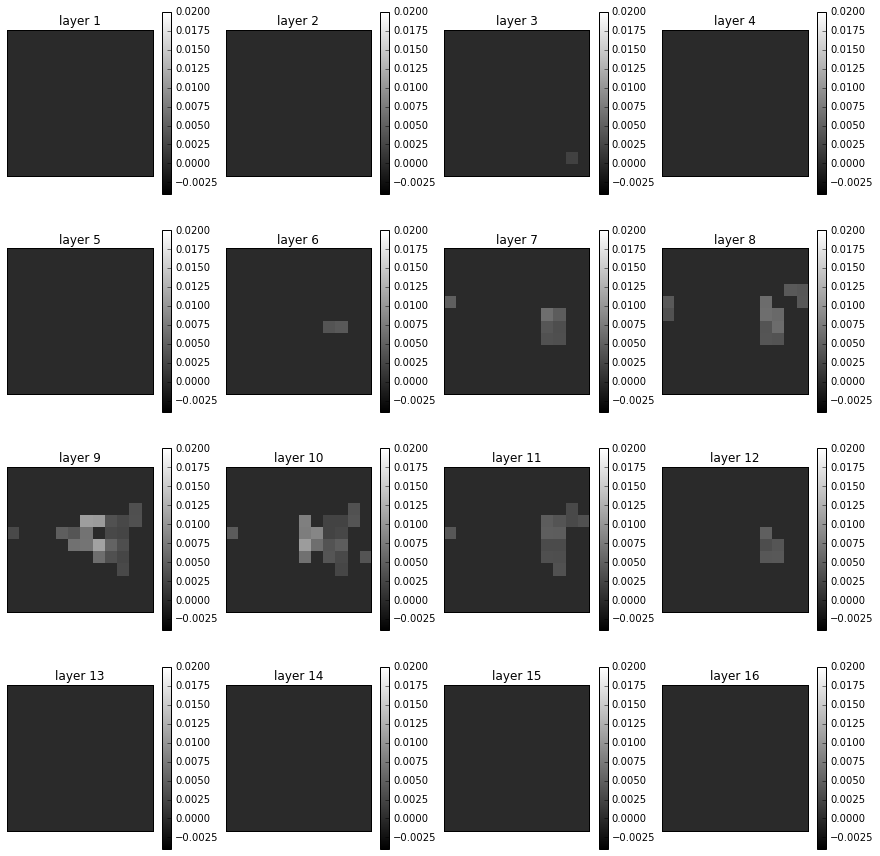

In [6]:
# plot results of independent voxel-wise fit masked based on perfusion threshold

def compute_mask(data, threshold):
    return (numpy.sum(numpy.abs(data[:, :, :, :, 0]), 3) > threshold)
    
mask = compute_mask(data, 3e9) # set threshold here 

plt.figure(figsize = (15,15))
for i in range(Nz):
    plt.subplot(4, 4, i+1)
    plt.imshow(mask[:, :, i]*kPL_fit[:, :, i], cmap="gray",  vmin=-0.004, vmax=0.02, interpolation="nearest")
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.title("layer " + str(i+1))
# plt.savefig('pc_data_3D_kPL_map_no_regularization_pefusion_thresholded.png', bbox_inches='tight')
plt.show()

In [7]:
## ADMM / Douglas-Rachford algorithm for parameter mapping 

import prox_tv as ptv

def theta_step_assumptionless(data, theta, z, u, rho, params, lambda2, Mzscale, Sscale): 
    
    # unpack params 
    dt    = params[0]
    N     = int(params[1])
    R1L   = params[2]
    R1P   = params[3]
    P0    = params[4]
    sigma = params[5]
    
    def func(theta, params, data):
        return numpy.hstack((data[:, 1] - traj_1D(theta, params, Mzscale, Sscale, data[:, 0]) , sqrt(0.5*rho)*(theta - z + u), sqrt(lambda2)*theta))
    
    theta0  = numpy.array([0.07])
    res = scipy.optimize.leastsq(func, theta0, args=(params, data))

    return res[0]

def theta_step_linear_least_squares(data, theta, z, u, rho, params): 
    # data represents times series from a particular voxel 
    
    # unpack params 
    dt    = params[0]
    N     = int(params[1])
    R1L   = params[2]
    R1P   = params[3]
    P0    = params[4]
    sigma = params[5]
    
    # extract relevant vectors 
    P_t      = data[:-1, 0]
    L_t      = data[:-1, 1]
    L_tplus1 = data[1:, 1]
        
    # set up A*theta = b 
    b = L_tplus1 - L_t + dt*R1L*L_t
    A = dt*P_t 
            
    # compute prox operator for 1/2 |A*theta - b|_2^2 
    M = (1/rho)*numpy.dot(A, A.T) + 1.0
    c = (1/rho)*numpy.dot(A, b.T) + z - u
    return c/M

def theta_step_maximum_likelihood(data, theta, z, u, rho, params, lambda2, Mzscale, Sscale, u0): 
    # data represents times series from a particular voxel 
    
    # unpack params 
    dt    = params[0]
    N     = int(params[1])
    R1L   = params[2]
    R1P   = params[3]
    P0    = params[4]
    sigma = params[5]
    
    def func(theta, params, Y, Mzscale, Sscale, u0):
        return numpy.hstack(((Y - trajectories(theta[0], theta[1], params, Mzscale, Sscale, u0)).flatten(), sqrt(0.5*rho)*(theta[1]- z + u), sqrt(lambda2)*theta[1]))

    x0  = numpy.array([0.05, 0.07])
    res = scipy.optimize.leastsq(func, x0, args=(params, data, Mzscale, Sscale, u0))

    return res[0][1]

def z_step(theta, z, u, lambda1, rho):    
    # return ptv.tv1_2d(rho/(2*lambda2 + rho)*(theta + u), lambda1/(lambda2 + 0.5*rho), n_threads=1)
    # return ptv.tv1_2d(theta + u, lambda1/rho, n_threads=1)
    return ptv.tvgen(theta + u, numpy.array([lambda1/rho, lambda1/rho, lambda1/rho]), [1, 2, 3], numpy.array([1, 1, 1]))

def u_step(theta, z, u):  
    return u + theta - z

## Prepare and test parallel map function 
import ipyparallel as ipp
c = ipp.Client()
dview = c[:]

with dview.sync_imports():
    import numpy
    import scipy
    import scipy.optimize

def pmap_ndarray(direct_view, f, *args):
    
    shape = args[0].shape
    
    # flatten arguments
    flattened_args = []
    for arg in args:
        assert(arg.shape == shape) # check that all args are the same shape 
        flattened_args.append(arg.flatten())
        
    # apply map function 
    y = direct_view.map_sync(f, *flattened_args)
    
    # reshape result to match shape of args
    return numpy.array(y).reshape(shape)

importing numpy on engine(s)
importing scipy on engine(s)
importing scipy.optimize on engine(s)


In [8]:
def ADMM_parallel_3D(data, lambda1, lambda2, rho, theta_est, z_est, u_est, method):
    theta = theta_est*numpy.ones((numpy.shape(data)[0], numpy.shape(data)[1], numpy.shape(data)[2]))
    z     =     z_est*numpy.ones((numpy.shape(data)[0], numpy.shape(data)[1], numpy.shape(data)[2]))
    u     =     u_est*numpy.ones((numpy.shape(data)[0], numpy.shape(data)[1], numpy.shape(data)[2]))
    
    # convert data to mappable format
    data_abstract = numpy.zeros(data.shape[0:3], dtype=numpy.ndarray)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            for k in range(data.shape[2]):
                data_abstract[i, j, k] = data[i, j, k, :, :]
    
    # iterate ADMM until convergence, or until we reach max_iter iterations 
    max_iters = 20
    min_iters = 10
    iterations = 0
    epsilon = 1e-3
    
    # theta_step_vectorized = numpy.vectorize(lambda w, x, y, z: theta_step(w, x, y, z, rho, params))
    u_step_vectorized = numpy.vectorize(u_step)
    
    # broadcast and load required packages, functions, variables 
    dview.push(dict(theta_step_linear_least_squares=theta_step_linear_least_squares, 
                    theta_step_maximum_likelihood=theta_step_maximum_likelihood,
                    theta_step_assumptionless=theta_step_assumptionless,
                    Mzscale=Mzscale,
                    Sscale=Sscale,
                    trajectories=trajectories,
                    traj_1D=traj_1D,
                    sqrt=sqrt,
                    u0=u0,
                    params=params))
    
    while (iterations < min_iters): 
        if (method == "linear-least-squares"):
            theta = pmap_ndarray(dview, lambda w, x, y, z: theta_step_linear_least_squares(w, x, y, z, rho, params, lambda2), data_abstract, theta, z, u)
        elif (method == "maximum-likelihood"):
            theta = pmap_ndarray(dview, lambda w, x, y, z: theta_step_maximum_likelihood(w, x, y, z, rho, params, lambda2, Mzscale, Sscale, u0), data_abstract, theta, z, u)
        elif (method == "assumption-less"):
            theta = pmap_ndarray(dview, lambda w, x, y, z: theta_step_assumptionless(w, x, y, z, rho, params, lambda2, Mzscale, Sscale), data_abstract, theta, z, u)
        else:
            raise ValueError("estimation method '%s' is not defined"%method)
        z     = z_step(theta, z, u, lambda1, rho)
        u     = u_step_vectorized(theta, z, u) # this can be parallelized too if we want, but it's fast
        iterations += 1
    
    while ((iterations < max_iters) and (numpy.linalg.norm(theta - z) > epsilon)):
        if (method == "linear-least-squares"):
            theta = pmap_ndarray(dview, lambda w, x, y, z: theta_step_linear_least_squares(w, x, y, z, rho, params, lambda2), data_abstract, theta, z, u)
        elif (method == "maximum-likelihood"):
            theta = pmap_ndarray(dview, lambda w, x, y, z: theta_step_maximum_likelihood(w, x, y, z, rho, params, lambda2, Mzscale, Sscale, u0), data_abstract, theta, z, u)
        elif (method == "assumption-less"):
            theta = pmap_ndarray(dview, lambda w, x, y, z: theta_step_assumptionless(w, x, y, z, rho, params, lambda2, Mzscale, Sscale), data_abstract, theta, z, u)
        else:
            raise ValueError("estimation method '%s' is not defined"%method)
        z     = z_step(theta, z, u, lambda1, rho)
        u     = u_step_vectorized(theta, z, u) # this can be parallelized too if we want, but it's fast
        iterations += 1

    print "iterations = ", iterations
    
    return theta

In [9]:
#         ADMM_parallel_3D(data, lambda1, lambda2, rho, theta_est, z_est, u_est, method)
kPL_map = ADMM_parallel_3D(data, 2e17, 1e14, 1e22, 0.0, 0.0, 0.0, "assumption-less")

iterations =  10


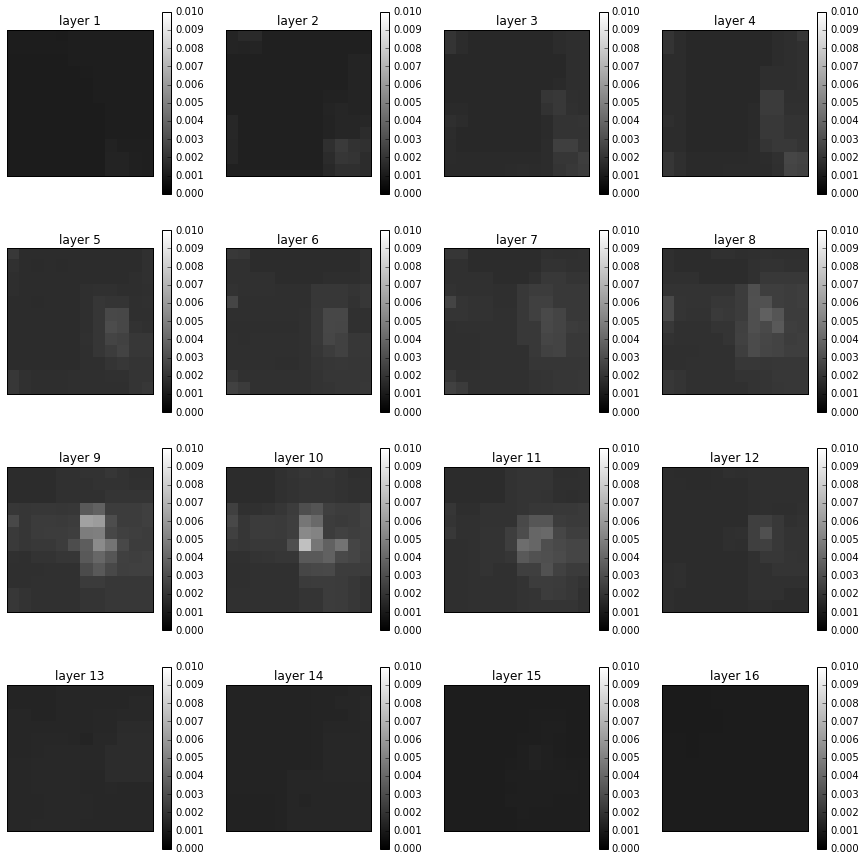

In [10]:
# plot slices of 3D parameter map 

plt.figure(figsize = (15,15))
for i in range(Nz):
    plt.subplot(4, 4, i+1)
    plt.imshow(kPL_map[:, :, i], cmap="gray", vmin=-0.000, vmax=0.010, interpolation="nearest")
    # plt.imshow(kPL_map[:, :, i], cmap="gray", vmin=-0.0001, vmax=0.005, interpolation="nearest")
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.title("layer " + str(i+1))
plt.savefig(filename + '_kPL_map_optimal_regularization.png', bbox_inches='tight')
plt.show()

In [11]:
# save computed parameter map in matlab format 
scipy.io.savemat('kPL_map_' + filename + '.mat', {"kPL_map": kPL_map})

In [5]:
def total_variation_3D(theta):
    d = 0
    for k in range(3):
        d += numpy.sum(numpy.abs(numpy.diff(theta, k)))
    return d

def objective_error(theta):
    for i in range(theta.shape[0]):
        print i

def Lcurve_lambda1(data, lambda1_min, lambda1_max, num_points_per_dimension, lambda2, rho):
    for lambda1 in numpy.logspace(lambda1_min, lambda1_max, num_points_per_dimension):
        kPL_map = ADMM_parallel_3D(data, lambda1, lambda2, rho, 0.0, 0.0, 0.0, "assumption-less")
        
        p1 = total_variation_3D(kPL_map)
        
        
        
        # this isn't right yet -- need to map over all voxels 
        p2 = objective_error(theta)
        # p2 = sum(abs(data[:, 1] - traj_1D(theta, params, Mzscale, Sscale, data[:, 0])))
    
